In [1]:
!pip install stellargraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 435 kB 14.4 MB/s 


In [2]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE
from stellargraph.layer import GAT

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets

from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
dataset = sg.datasets.PubMedDiabetes()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [5]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 19717, Edges: 44338

 Node types:
  paper: [19717]
    Features: float32 vector, length 500
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [44338]
        Weights: all 1 (default)
        Features: none


In [6]:
node_subjects.value_counts().to_frame()

,label
2,7875
3,7739
1,4103


In [7]:
#جداسازی داده ها
train_subjects, test_subjects = model_selection.train_test_split( node_subjects, train_size=140, test_size=None, stratify=node_subjects)

val_subjects, test_subjects = model_selection.train_test_split(test_subjects, train_size=500, test_size=None, stratify=test_subjects)

In [8]:
#تبدیل به بردار (one-hot)
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)
print (test_targets[6])

[0 0 1]


In [9]:
#این کلاس در واقع اطلاعات گراف را برای ورودی مدل میتواند آماده کند
generator = FullBatchNodeGenerator(G, method="gcn")

Using GCN (local pooling) filters...


In [10]:
#داده های ورودی را اماده میکنیم
train_gen = generator.flow(train_subjects.index, train_targets)
train_gen[0,5,4]

([array([[[0.09393489, 0.02869846, 0.01176013, ..., 0.        ,
           0.        , 0.        ],
          [0.02361792, 0.        , 0.01478416, ..., 0.        ,
           0.        , 0.        ],
          [0.10226315, 0.        , 0.01066898, ..., 0.        ,
           0.        , 0.        ],
          ...,
          [0.06794195, 0.        , 0.01417659, ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.0092401 , ..., 0.        ,
           0.        , 0.        ],
          [0.17505044, 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ]]], dtype=float32),
  array([[10543,  9200,  3002, 17393,  3596,  6950, 19371, 15948,  1204,
          14553, 14274,  1701,  9946,  2426,  4302,  8186,  5159,  5650,
          15458, 11131,  9585,  6177,  9256, 15110, 14495, 16701,  4444,
           5448,   600, 19243, 14917, 10840,  6799,  7514, 18995, 10592,
           1335, 12463, 11151, 11501, 11825, 11294, 17118, 13261,  5031,
  

In [11]:
#.مشخصات مدل را می دهیم.مدل شامل دولایه که هرکدام 16 نود دارند و فعالسازشان رلیو است می باشد.نصف داده هارا هم به عنوان دراپ اوت در نظر میگیریم ومدل را ایجاد میکنیم
gcn = GCN(layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5)

In [12]:
#خروجی یک بردار 16 بعدی را برای هر گره در هنگام اموزش یا پیش بینی نگه میدارد.وپیش بینی واقعی هرگره از این بردار محاسبه میشود.یک لایه اضافی با یک نود هم دارد که از سافت مکس استفاده میکند برای محاسبه احتمال هرکلاس
x_inp, x_out = gcn.in_out_tensors()

x_out

<KerasTensor: shape=(1, None, 16) dtype=float32 (created by layer 'gather_indices')>

In [13]:
#prediction برابر است با بیشترین مقدار سافت مکس در واقع یک لایه اضافه کردیم با فعالساز سافت مکس که برحسب ایکس اوت برچسب نود را پیش بینی کند
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [14]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
#میخواهیم عملکرد را در داده های ارزیابی هم حفظ کنیم ،یعنی یک مولد داده های دیگر هم باید ایجاد کنیم برای داده های ارزیابی
val_gen = generator.flow(val_subjects.index, val_targets)

In [16]:
#یک مقدار توقف برای ایپوک هاست که اگر دقت بهتر نشد دیگه ادامه ندهد
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=100, restore_best_weights=True)

**GCN**

In [17]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
1/1 - 3s - loss: 1.0960 - acc: 0.4571 - val_loss: 1.0800 - val_acc: 0.4420 - 3s/epoch - 3s/step
Epoch 2/200
1/1 - 0s - loss: 1.0806 - acc: 0.4929 - val_loss: 1.0627 - val_acc: 0.4060 - 309ms/epoch - 309ms/step
Epoch 3/200
1/1 - 0s - loss: 1.0622 - acc: 0.4571 - val_loss: 1.0454 - val_acc: 0.3980 - 323ms/epoch - 323ms/step
Epoch 4/200
1/1 - 0s - loss: 1.0441 - acc: 0.4214 - val_loss: 1.0277 - val_acc: 0.3980 - 312ms/epoch - 312ms/step
Epoch 5/200
1/1 - 0s - loss: 1.0256 - acc: 0.4714 - val_loss: 1.0094 - val_acc: 0.4040 - 325ms/epoch - 325ms/step
Epoch 6/200
1/1 - 0s - loss: 1.0084 - acc: 0.4786 - val_loss: 0.9907 - val_acc: 0.4820 - 315ms/epoch - 315ms/step
Epoch 7/200
1/1 - 0s - loss: 0.9824 - acc: 0.5143 - val_loss: 0.9711 - val_acc: 0.5540 - 321ms/epoch - 321ms/step
Epoch 8/200
1/1 - 0s - loss: 0.9716 - acc: 0.5500 - val_loss: 0.9505 - val_acc: 0.6240 - 307ms/epoch - 307ms/step
Epoch 9/200
1/1 - 0s - loss: 0.9353 - acc: 0.6000 - val_loss: 0.9291 - val_acc: 0.6720 - 312ms

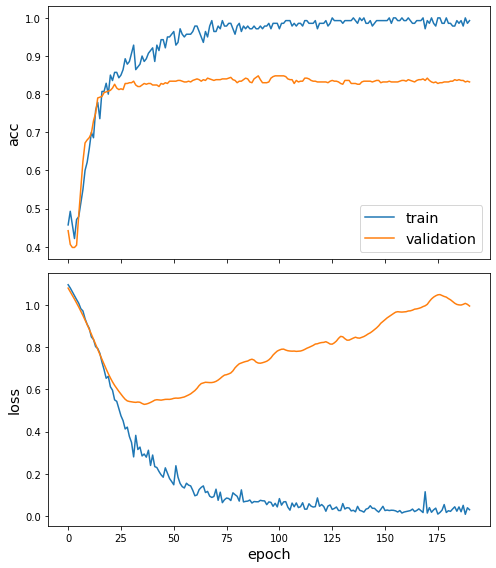

In [18]:
sg.utils.plot_history(history)

In [19]:
#مولد تولید داده های تست
test_gen = generator.flow(test_subjects.index, test_targets)

In [20]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 170ms/step - loss: 0.7581 - acc: 0.8170

Test Set Metrics:
	loss: 0.7581
	acc: 0.8170


In [21]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [22]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [23]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
pid,,
12187484,1,1
2344352,1,1
14654069,1,1
16443886,3,2
2684155,1,1
15032912,3,1
17988185,3,3
9834350,3,3
16230722,3,3


[link text](https://)**Creating the GraphSAGE model**


In [24]:
batch_size = 50
num_samples = [10, 5]
generator = GraphSAGENodeGenerator(G, batch_size, num_samples)
train_gen = generator.flow(train_subjects.index, train_targets, shuffle=True)
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5,
)

x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [25]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [26]:
test_gen = generator.flow(test_subjects.index, test_targets)


In [27]:
history = model.fit(
    train_gen, epochs=20, validation_data=test_gen, verbose=2, shuffle=False
)

Epoch 1/20
3/3 - 15s - loss: 1.0619 - acc: 0.4429 - val_loss: 1.0204 - val_acc: 0.5465 - 15s/epoch - 5s/step
Epoch 2/20
3/3 - 21s - loss: 0.9812 - acc: 0.6286 - val_loss: 0.9797 - val_acc: 0.6145 - 21s/epoch - 7s/step
Epoch 3/20
3/3 - 18s - loss: 0.9239 - acc: 0.6286 - val_loss: 0.9110 - val_acc: 0.6077 - 18s/epoch - 6s/step
Epoch 4/20
3/3 - 12s - loss: 0.8355 - acc: 0.7143 - val_loss: 0.8276 - val_acc: 0.6612 - 12s/epoch - 4s/step
Epoch 5/20
3/3 - 11s - loss: 0.7819 - acc: 0.7429 - val_loss: 0.7683 - val_acc: 0.7257 - 11s/epoch - 4s/step
Epoch 6/20
3/3 - 11s - loss: 0.6985 - acc: 0.8429 - val_loss: 0.7253 - val_acc: 0.7543 - 11s/epoch - 4s/step
Epoch 7/20
3/3 - 13s - loss: 0.6440 - acc: 0.8714 - val_loss: 0.6880 - val_acc: 0.7707 - 13s/epoch - 4s/step
Epoch 8/20
3/3 - 17s - loss: 0.5636 - acc: 0.9214 - val_loss: 0.6546 - val_acc: 0.7829 - 17s/epoch - 6s/step
Epoch 9/20
3/3 - 12s - loss: 0.5119 - acc: 0.9286 - val_loss: 0.6333 - val_acc: 0.7840 - 12s/epoch - 4s/step
Epoch 10/20
3/3 - 2

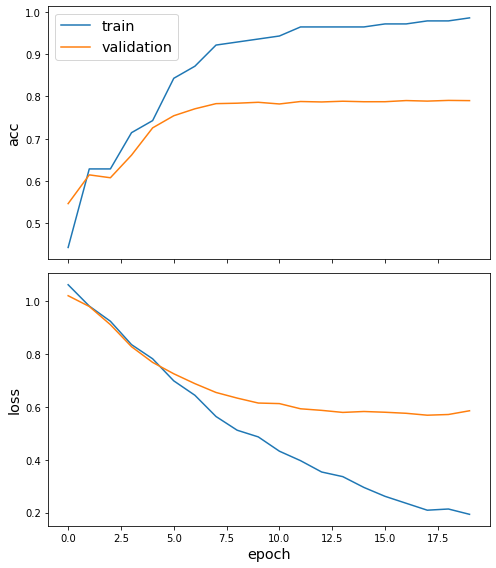

In [28]:
sg.utils.plot_history(history)


In [29]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

382/382 [==============================] - 12s 31ms/step - loss: 0.5855 - acc: 0.7882

Test Set Metrics:
	loss: 0.5855
	acc: 0.7882


In [30]:
all_nodes = node_subjects.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict(all_mapper)

node_predictions1 = target_encoding.inverse_transform(all_predictions)


df = pd.DataFrame({"Predicted": node_predictions1, "True": node_subjects})
df.head(20)

,Predicted,True
pid,,
12187484,1,1
2344352,1,1
14654069,1,1
16443886,2,2
2684155,1,1
15032912,3,1
17988185,3,3
9834350,3,3
16230722,3,3


**Creating the GAT model**

In [31]:
generator = FullBatchNodeGenerator(G, method="gat")
train_gen = generator.flow(train_subjects.index, train_targets)
gat = GAT(
    layer_sizes=[8, train_targets.shape[1]],
    activations=["relu", "softmax"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.5,
    attn_dropout=0.5,
    normalize=None,
)

x_inp, predictions = gat.in_out_tensors()


In [32]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [33]:
val_gen = generator.flow(val_subjects.index, val_targets)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

if not os.path.isdir("logs"):
    os.makedirs("logs")
es_callback = EarlyStopping(
    monitor="val_acc", patience=20
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
)

In [34]:
history = model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Epoch 1/50
1/1 - 5s - loss: 1.1027 - acc: 0.3143 - val_loss: 1.0884 - val_acc: 0.4820 - 5s/epoch - 5s/step
Epoch 2/50
1/1 - 1s - loss: 1.0890 - acc: 0.4571 - val_loss: 1.0763 - val_acc: 0.5820 - 1s/epoch - 1s/step
Epoch 3/50
1/1 - 1s - loss: 1.0781 - acc: 0.4929 - val_loss: 1.0638 - val_acc: 0.6640 - 1s/epoch - 1s/step
Epoch 4/50
1/1 - 1s - loss: 1.0609 - acc: 0.5714 - val_loss: 1.0510 - val_acc: 0.6740 - 1s/epoch - 1s/step
Epoch 5/50
1/1 - 1s - loss: 1.0469 - acc: 0.5857 - val_loss: 1.0379 - val_acc: 0.6720 - 1s/epoch - 1s/step
Epoch 6/50
1/1 - 1s - loss: 1.0299 - acc: 0.5500 - val_loss: 1.0245 - val_acc: 0.6740 - 1s/epoch - 1s/step
Epoch 7/50
1/1 - 1s - loss: 1.0278 - acc: 0.5929 - val_loss: 1.0112 - val_acc: 0.6780 - 1s/epoch - 1s/step
Epoch 8/50
1/1 - 1s - loss: 1.0144 - acc: 0.5286 - val_loss: 0.9978 - val_acc: 0.6780 - 1s/epoch - 1s/step
Epoch 9/50
1/1 - 1s - loss: 0.9937 - acc: 0.6071 - val_loss: 0.9843 - val_acc: 0.6820 - 1s/epoch - 1s/step
Epoch 10/50
1/1 - 1s - loss: 0.9716 -

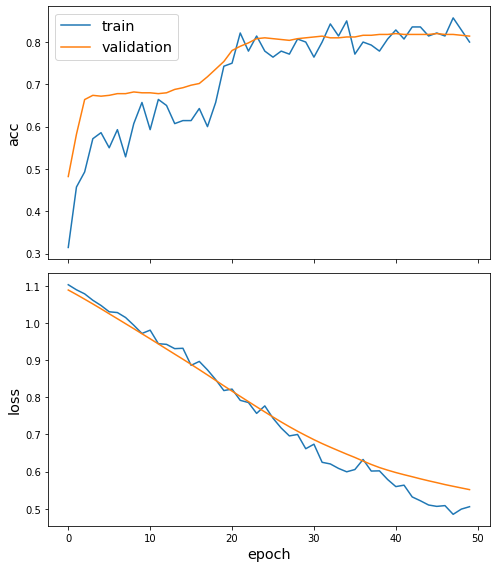

In [35]:
sg.utils.plot_history(history)


In [36]:
test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 250ms/step - loss: 0.5529 - acc: 0.8012

Test Set Metrics:
	loss: 0.5529
	acc: 0.8012


In [37]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
pid,,
12187484,1,1
2344352,1,1
14654069,1,1
16443886,3,2
2684155,1,1
15032912,3,1
17988185,3,3
9834350,3,3
16230722,3,3
